In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hmmlearn import hmm

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")

# Original data downloaded from: https://www.gold.org/goldhub/data/gold-prices
# An account is required to download the data in .xlsx format. 
# I extracted the daily closing gold price in USD from the .xlsx file and saved them as .csv

base_dir = "gold/"

data = pd.read_csv(base_dir + "gold_price_usd.csv")

data["datetime"] = pd.to_datetime(data["datetime"])

data["gold_price_change"] = data["gold_price_usd"].diff()

data = data[data["datetime"] >= pd.to_datetime("2008-01-01")]

display(data)

,datetime,gold_price_usd,gold_price_change
7567,2008-01-01,833.8,0.0
7568,2008-01-02,846.8,13.0
7569,2008-01-03,858.9,12.1
7570,2008-01-04,855.0,-3.9
7571,2008-01-07,859.3,4.3
...,...,...,...
10951,2020-12-21,1880.0,0.2
10952,2020-12-22,1877.1,-2.9
10953,2020-12-23,1875.0,-2.1
10954,2020-12-24,1875.0,0.0


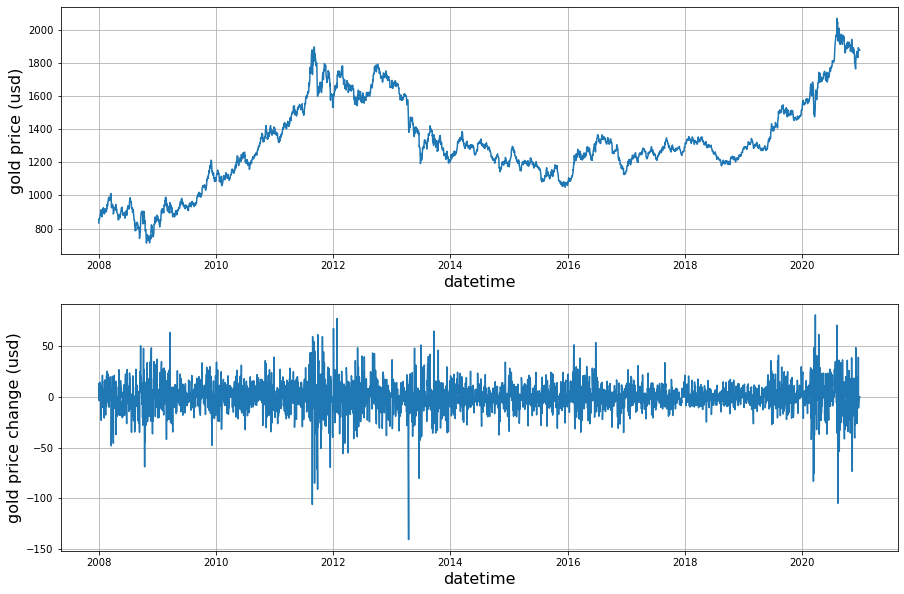

In [100]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["datetime"], data["gold_price_usd"])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["datetime"], data["gold_price_change"])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.grid(True)
plt.show()

In [78]:
# Build hidden markov models to model the change in gold price

# Hidden Markov Models
# --------------------
# Inputs
# ------
# X: np.array of observable states
# Outputs
# -------
# Z: np.array of hidden internal states corresponding to X
# Model Parameters
# ----------------
# startprob_: np.array of start probabilities
# transmat_: np.array of internal states transition
# means_: np.array of observable emission probability means
# covars_: np.array of observable emission probability covariances

def gaussian_emission(mu, var):
    """
    Inputs
    ------
    mu: float
        mean
    var: float
        variance
        
    Returns
    -------
    r: float
        sample from gaussian distribution
    """
    r = np.random.normal(mu, np.sqrt(var))
    return r

X = data[["gold_price_change"]].values
model = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 50)
model.fit(X)
Z = model.predict(X)
states = pd.unique(Z)

print("Unique states:")
print(states)
print("Start probabilities:")
print(model.startprob_)
print("Transition matrix:")
print(model.transmat_)
print("Gaussian distribution means:")
print(model.means_)
print("Gaussian distribution covariances:")
print(model.covars_)

Unique states:
[0 1 2]
Start probabilities:
[1.00000000e+00 5.29883044e-19 1.54235262e-47]
Transition matrix:
[[0.517183   0.47967295 0.00314405]
 [0.61275004 0.38237486 0.00487511]
 [0.00405087 0.01338607 0.98256305]]
Gaussian distribution means:
[[ 0.37687489]
 [ 0.55767564]
 [-0.36083256]]
Gaussian distribution covariances:
[[[ 37.91291431]]

 [[228.94362898]]

 [[620.11351247]]]


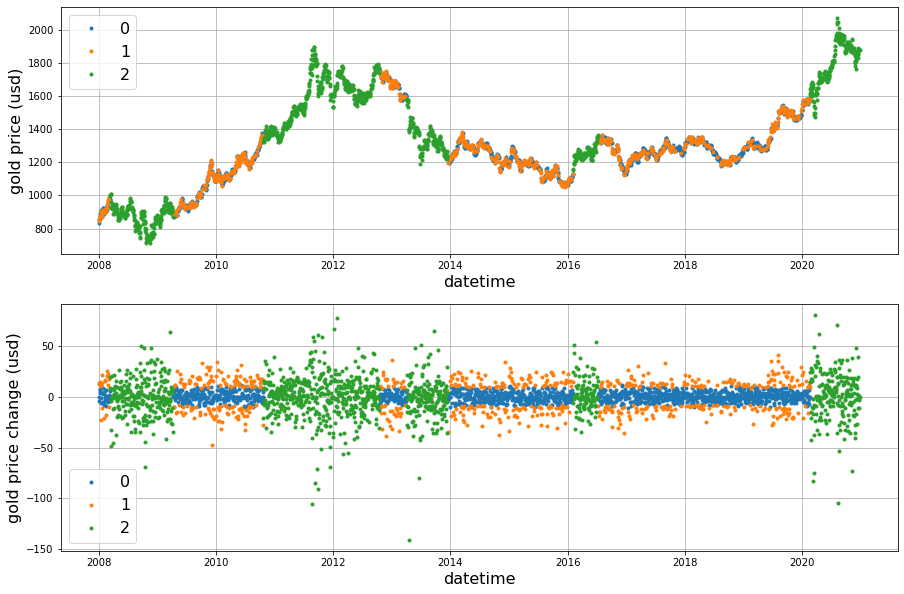

In [79]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_usd"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_change"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.show()

In [ ]:
# Prepare the data for LSTM neural network modelling 
dataset = data["gold_price_usd"].values
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

data["gold_price_scaled"] = dataset.copy()

# use 2010-2018 as the training set, and 2019-2020 as the test set
train = data[data["datetime"] < pd.to_datetime("2019-01-01")]["gold_price_scaled"].values
test = data[data["datetime"] >= pd.to_datetime("2019-01-01")]["gold_price_scaled"].values

In [ ]:
def create_lstm_data(data, lag = 1):
    """
    Creates features and targets suitable for LSTM modelling
    
    Inputs
    ------
    data: np.array
        One dimensional time series np.array to be processed
        This array should not have undergone the process: .reshape(-1, 1)
    lag: int
        Amount of historical lag used to create the feature set
    
    Outputs
    -------
    X, y: np.array, np.array
        Feature and target arrays
    """
    if lag > len(data):
        # lag cannot be more than data length
        return None
    
    if len(np.shape(data)) > 1 and np.shape(data)[1] == 1:
        # if for some reason data was detected to have undergone reshape(-1, 1)
        # force it back to a standard 1 dimensional np.array
        data = data.reshape(-1)
    elif len(np.shape(data)) > 1 and np.shape(data)[1] > 1:
        # this function works only for 1D arrays. Anything more than that will not work
        return None
        
    # If there are no pressing issues, create the LSTM compatible data 
    # with the specified historical lag
    X = np.zeros([len(data) - lag, lag])
    y = np.zeros(len(data) - lag)
    for n in range(len(data) - lag):
        X[n] = data[n:n + lag]
        y[n] = data[n + lag]
    
    X = X.reshape([X.shape[0], 1, X.shape[1]])
    
    return X, y

def demo():
    # demonstrates how to use create_lstm_data()
    X = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                  11, 12, 13, 14, 15, 16, 17 ,18 ,19, 20])
    X, y = create_lstm_data(X, 3)

    for i in range(len(X)):
        print(X[i], y[i])

In [ ]:
lag = 30 # lag of N days

# train X and y
X_train, y_train = create_lstm_data(train, lag)
# test X and y
X_test, y_test = create_lstm_data(test, lag)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
# wrapper function to build the LSTM model
def make_lstm_model(X_train, y_train, units=50, epochs=100, batch_size=32, verbose=2):
    model = Sequential()
    model.add(LSTM(units = units, input_shape = [X_train.shape[1], X_train.shape[2]], activation = "relu"))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = verbose)
    
    return model

In [ ]:
models = []
y_train_preds = []
y_test_preds =[]

n_models = 10 # number of models to make

for i in range(n_models):
    # build LSTM model using X_train and y_train
    model = make_lstm_model(X_train, y_train, units=50, epochs=20, batch_size=32, verbose=0)
    
    # make predictions on both X_train and X_test which the model has not seen before
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # don't forget to perform the inverse scaling operations!
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    
    models.append(model)
    y_train_preds.append(y_train_pred)
    y_test_preds.append(y_test_pred)

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

print(y_train.shape, y_test.shape)

In [ ]:
# Check the RMSE per model
train_scores = []
test_scores = []

for i in range(n_models):
    train_score = np.sqrt(mean_squared_error(y_train, y_train_preds[i]))
    test_score = np.sqrt(mean_squared_error(y_test, y_test_preds[i]))
    train_scores.append(train_score)
    test_scores.append(test_score)
    
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + n_models), train_scores)
plt.plot(range(1, 1 + n_models), test_scores)
plt.xlabel("Model number", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.grid(True)
plt.legend(["Train", "Test"], fontsize=16)
plt.show()

In [ ]:
# Check how the loss changes with epochs
plt.figure(figsize = (15, 5))
for i in range(len(models)):
    plt.plot(models[i].history.history['loss'], 'k')
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
# plot the best performing model:
want = np.argmin(test_scores)

plt.figure(figsize = (15, 5))
plt.plot(data["datetime"], scaler.inverse_transform(dataset))
plt.plot(data["datetime"].iloc[lag:len(y_train_pred) + lag], y_train_preds[want])
plt.plot(data["datetime"].iloc[len(y_train_pred) + lag + lag:], y_test_preds[want])
plt.legend(["Data", "Train", "Test"], fontsize=16)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.grid(True)
#plt.xlim([pd.to_datetime("2019-01-01"), pd.to_datetime("2021-01-01")])
plt.show()